In [1]:
from itertools import combinations,combinations_with_replacement
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
from xml.etree import cElementTree as ET
import sys
import numpy as np

color_map = {0:'r', 1:'b', 2:'g', 3:'black', 4:'orangered', 5:'m', 6:'y'}

def poly_value(coef_vec,x):
    value = 0
    reverse_vec = coef_vec
    reverse_vec.reverse()
    for coef in reverse_vec:
        value = coef + value*x
    return value

class Pos:
    
    def __init__(self,i = 0,j = 0):
        self.i = i
        self.j = j
        
    def __str__(self):
        return f'({self.i},{self.j})'
    
    def __add__(self, other):
        #радиус-вектор
        return Pos(self.i+other.i,self.j+other.j)
    
    def __sub__(self, other):
        return Pos(self.i-other.i,self.j-other.j)
    
    def __mul__(self, other):
        try:
            return Pos(self.i*other,self.j*other)
        except:
            print(f'{type(self)} and {type(other)} are not multiply')
    
    def __truediv__(self, other):
        try:
            return Pos(self.i/other,self.j/other)
        except:
            print(f'{type(self)} and {type(other)} are not divisible')
    
    
    def around(self, dist = 1):
        neighbors = [self]
        if dist >= 1:
            for x in range(1,dist+1):
                neighbors += [Pos(self.i-x,self.j),Pos(self.i+x,self.j),
                              Pos(self.i,self.j-x),Pos(self.i,self.j+x)]
            for x in range(1,dist+1):
                for y in range(1,int((dist**2 - x**2)**0.5) + 1):
                    if x**2 + y**2 <= dist**2:
                        neighbors += [Pos(self.i-x,self.j-y),Pos(self.i-x,self.j+y),
                                      Pos(self.i+x,self.j-y),Pos(self.i+x,self.j+y),
                                      Pos(self.i-y,self.j-x),Pos(self.i-y,self.j+x),
                                      Pos(self.i+y,self.j-x),Pos(self.i+y,self.j+x),]
                    
        return neighbors

    
    def get_distance(self,other,mode=0):
        if mode:
            return abs(self.i - other.i) + abs(self.j - other.j)
        return ((self.i - other.i)**2 + (self.j - other.j)**2)**0.5
    
    def is_around(self, other, dist=1):
        return self.get_distance(other) <= dist

    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        return hash((self.i,self.j))
    
    
class Agent:
        
    def __init__(self,player_id = None,pos = None):
        self.player_id = player_id
        self.pos = pos
        
    def __str__(self):
        return f'<player_id = {self.player_id}, pos = {self.pos}>'
    
    def is_neighbour(self,other,dist):
        return self.pos.is_around(other.pos,dist)
    
    def neighbors_pos(self,dist=1):
        return self.pos.around(dist)

    
class Network:
    
    def __init__(self):
        self.agents = []
        self.drons = []
        self.graph = nx.Graph()
        self.players_id = []
        self.r = 1 #радиус 
        
    def __str__(self):
        return f'<agents = {list(map(str,self.agents))}>'
        
    def add_agent(self, new_agent):
        neighbours = []
        for obj in (self.agents):
            if obj.player_id == new_agent.player_id :
                if obj.pos.get_distance(new_agent.pos) <= self.r:
                    neighbours.append(obj)
                    
        for obj in (self.drons):
            if obj.pos.get_distance(new_agent.pos) <= self.r:
                neighbours.append(obj)            
        
        self.graph.add_node(new_agent)  
        
        if new_agent.player_id not in self.players_id:
            self.players_id.append(new_agent.player_id)
        self.graph.add_node(new_agent)
            
        for neighbour in neighbours:
            if new_agent.player_id == neighbour.player_id:
                self.graph.add_edge(new_agent,neighbour)
            
        self.agents.append(new_agent)

        
    def add_agents(self, new_agent_list):
        for new_agent in new_agent_list:
            self.add_agent(new_agent)
            
    def add_dron(self, new_dron):            
        neighbours = []
        for obj in (self.drons+self.agents):
            if obj.pos.get_distance(new_dron.pos) <= self.r:
                neighbours.append(obj)
        self.graph.add_node(new_dron)  
        
        if len(neighbours) > 0:
            for neighbour in neighbours:
                self.graph.add_edge(new_dron,neighbour)

                    
        self.drons.append(new_dron)
        
    def add_drons(self, new_dron_list):
        for new_dron in new_dron_list:
            self.add_dron(new_dron)
            
    def del_dron(self, dron):
        if self.drons.count(dron) != 0:
            self.drons.remove(dron)
            self.graph.remove_node(dron)
                
    def del_drons(self, drons_list):
        for dron in drons_list:
            self.del_dron(dron)
        
    def create_graph(self):
        self.graph = nx.Graph()
        for agent in self.agents:
            self.graph.add_node(agent)
        for agent in self.agents:
            for other_agent in self.agents:
                if agent.is_neighbour(other_agent) and agent.player_id == other_agent.player_id:
                    self.graph.add_edge(agent,other_agent) 
                    
        for dron in self.drons:
            self.graph.add_node(dron)
        for dron in self.drons:
            for other in (self.drons+self.agents):
                if dron.is_neighbour(other):
                    self.graph.add_edge(dron,other)        
        return self.graph
            
    def draw_graph(self, visible_players_list = None,possible_positions = None,pngname=None):   
        G = self.graph.copy()
        G.remove_nodes_from(self.drons)
        subgraphs = [G.subgraph(c) for c in nx.connected_components(G)]
#         Упорядочим подграфы по номерам игроков
        subgraphs = {list(subgraph)[0].player_id: subgraph for subgraph in subgraphs}
        if visible_players_list == None:
            visible_players_list = list(subgraphs.keys())
        pos = {agent: (agent.pos.i+agent.player_id*0.1,agent.pos.j-agent.player_id*0.1) for agent in self.agents}
        pos.update({dron: (dron.pos.i,dron.pos.j) for dron in self.drons})     
        for i in visible_players_list:   
            nx.draw_networkx_nodes(self.graph, pos, node_size=150, nodelist=subgraphs[i], node_color=color_map[i-1])
        nx.draw_networkx_nodes(self.graph, pos, node_size=150, nodelist=self.drons, node_color="gold") 
        nx.draw_networkx_edges(self.graph, pos, edgelist = self.graph.edges, alpha=0.5, width=1)
        
        if possible_positions != None:
            possible_drons = [Agent(pos=possible_position) for possible_position in possible_positions]  
            self.graph.add_nodes_from(possible_drons)
            pos = {possible_dron: (possible_dron.pos.i,possible_dron.pos.j) for possible_dron in possible_drons}
            nx.draw_networkx_nodes(self.graph, pos, node_size=150, nodelist=possible_drons, node_color="black", node_shape = "s")    
            nx.draw_networkx_nodes(self.graph, pos, node_size=120, nodelist=possible_drons, node_color="w", node_shape = "s")
            self.graph.remove_nodes_from(possible_drons)
        plt.axis("on")
        if pngname != None:
            plt.savefig(pngname)
        plt.show()
    
    def get_player_subnet(self, p_id, with_drons=False):
        subgraph = self.graph.copy()
        remove_list = []
        for node in subgraph.nodes:
            if node.player_id != p_id:
                if not with_drons:
                    remove_list.append(node)
                elif node.player_id != 0:
                    remove_list.append(node)
        subgraph.remove_nodes_from(remove_list)
        if with_drons:
            nodes = []
            for node in list(subgraph.nodes):
                if node.player_id != 0:
                    nodes.append(node)
        else:
            nodes = list(subgraph.nodes)
        subnet = Network()
        subnet.add_agents(nodes)
        if with_drons:
            subnet.add_drons(self.drons)
        return subnet
        
    def get_possible_grid_positions(self):
        positions = set()
        agents_pos = {}
        for agent in network.agents:
            positions.update(agent.neighbors_pos(network.r))
        possible_positions = []

        for pos in positions:
            player_list = set()
            for agent in network.agents:
                if pos.get_distance(agent.pos) <= network.r:
                    player_list.add(agent.player_id)
                    if len(player_list) > 1:
                        break
            if len(player_list) > 1:
                possible_positions.append(pos)
        return possible_positions
 

    def get_possible_positions(self):
        a = tuple(set(self.agents))
        intersections = [[],[]]
        for p1 in range(len(a)):
            for p2 in range(p1+1,len(a)):
                dist = a[p1].pos.get_distance(a[p2].pos)
                if dist == 0:
                    if a[p1].player_id != a[p2].player_id:
                        intersections[0] += [[]]
                        intersections[1] += [a[p1].pos]
                elif dist <= 2*self.r:
                    h = (self.r**2-(dist/2)**2)**0.5
                    p12 = (a[p2].pos-a[p1].pos)
                    center = a[p1].pos + p12/2
                    intersections[0] += [[],[]]
                    intersections[1] += [Pos(center.i+(h/dist)*p12.j,center.j-(h/dist)*p12.i),
                                         Pos(center.i-(h/dist)*p12.j,center.j+(h/dist)*p12.i)]


        for i in range(len(intersections[1])):
            for agent in a:
                if intersections[1][i].get_distance(agent.pos) <= self.r:
                    intersections[0][i].append(agent)

        intersection_dict = {}
        for point_set,point in zip(intersections[0],intersections[1]):  
            one_player = True
            for p in point_set:
                if p.player_id != point_set[0].player_id:
                    one_player = False
                    break
            if one_player == False:
                max_len = 0
                for intersection in intersections[0]:
                    if set(point_set).issubset(set(intersection)):
                        if max_len < len(intersection):
                            max_len = len(intersection)
                            max_intersection = intersection

                if len(point_set) == max_len:       
                    point_set = tuple(point_set)
                    if intersection_dict.get(point_set) == None:
                        intersection_dict[point_set] = [point]
                    else:
                        intersection_dict[point_set].append(point)

        values = list(intersection_dict.values())
        return list(map(lambda x: np.mean(np.array(x)),values))



    def get_pos_value(self,alpha,position):
        dron = Agent(pos = position)
        self.add_dron(dron)
        value = self.get_value(alpha)
        self.del_dron(dron)
        return value 
    
    def get_value(self,alpha):
        len_ways_vec = [0 for i in range(len(self.agents)+len(self.drons))] 
        shotest_ways = []
        for s in self.agents:
            for t in self.agents:
                if s.player_id != t.player_id: 
                    if nx.has_path(self.graph, source=s, target=t):
                        for path in list(nx.all_shortest_paths(self.graph, source=s, target=t)):
                            shotest_ways.append(path)
#         Считаем производящую функцию сразу для всех дронов
        for path in shotest_ways:
            for dron in self.drons:
                if dron in list(path):
                    len_ways_vec[len(path)-1] += 1/len(path)
                    break                  
                
        return poly_value(len_ways_vec[1:],alpha)

    
    def get_best_positions(self,possible_positions,alpha,drons_count=None):
        if drons_count == None:
            drons_count = len(self.players_id)-1
        max_value = 0
        best_set = None

        if len(possible_positions) >= drons_count:
            for positions in combinations(possible_positions, drons_count):
                drons = [Agent(pos = position) for position in positions]
                network.add_drons(drons)
                if nx.is_connected(network.graph):
                    cur_value = network.get_value(alpha)
                    print([str(dron.pos) for dron in drons],cur_value)
                    if max_value < cur_value:
                        max_value = cur_value
                        best_set = positions
                network.del_drons(drons)

        else:
            for positions in combinations_with_replacement(possible_positions, drons_count):
                drons = [Agent(pos = position) for position in positions]
                network.add_drons(drons)
                if nx.is_connected(network.graph):
                    cur_value = network.get_value(alpha)
                    print([str(dron.pos) for dron in drons],cur_value)
                    if max_value < cur_value:
                        max_value = cur_value
                        best_set = positions
                network.del_drons(drons)

        return best_set
    
    

        
    
    def write_info_file(self,drons_pos=None,filename = 'my_network_with_nodes.txt'):
        if type(drons_pos) is list or type(drons_pos) is tuple:
            drons_list = [Agent(pos = dron_pos) for dron_pos in drons_pos]
            self.add_drons(drons_list)
#             print(list(map(str,drons_pos)))
#             self.draw_graph()
            adj_matrix = nx.to_numpy_matrix(self.graph,dtype ='int')
        elif type(drons_pos) is Pos:   
            dron = Agent(pos = drons_pos)
            self.add_dron(dron)
#             print(drons_pos)
#             self.draw_graph()
            adj_matrix = nx.to_numpy_matrix(self.graph,dtype ='int')
        else:
            adj_matrix = nx.to_numpy_matrix(self.graph,dtype ='int')
        with open(filename,'w') as file:
            file.write(str(len(self.agents))+' '+str(len(self.drons))+'\n')
            for agent in self.agents:
                file.write(str(agent.pos.i) + ' ' + str(agent.pos.j) + ' ' + str(agent.player_id) +'\n')
            for dron in self.drons:
                file.write(str(dron.pos.i) + ' ' + str(dron.pos.j) + '\n')
            str_matrix = ''
            for i in range(adj_matrix.shape[0]):     
                for j in range(adj_matrix.shape[1]):
                    str_matrix += (str(adj_matrix[i,j])+' ')
                str_matrix += '\n'
            file.write(str_matrix)
                 
        subnetA = self.get_player_subnet(1,True)
        if type(drons_pos) is list or type(drons_pos) is tuple:
            for dron in drons_list.copy():
                if len(list(subnetA.graph.neighbors(dron))) < 2:
                    subnetA.del_dron(dron)
        elif type(drons_pos) is Pos:
            if len(list(subnetA.graph.neighbors(dron))) < 2:
                subnetA.del_dron(dron)
                
        subnetB = self.get_player_subnet(2,True)  
        if type(drons_pos) is list or type(drons_pos) is tuple:
            for dron in drons_list.copy():
                if len(list(subnetB.graph.neighbors(dron))) < 2:
                    subnetB.del_dron(dron)
        elif type(drons_pos) is Pos:
            if len(list(subnetB.graph.neighbors(dron))) < 2:
                subnetB.del_dron(dron)
        
        if type(drons_pos) is list or type(drons_pos) is tuple:
            self.del_drons(drons_list)
        elif type(drons_pos) is Pos:
            self.del_dron(dron)
            


In [2]:
def parse_flowmon(info_xml = 'p2p_manet.flowmon'):
    et=ET.parse(info_xml)
    txPackets = []
    rxPackets = []
    lostPackets = []
    delays = []

    for flow in et.iterfind('FlowStats/Flow'):
        txPackets.append(int(flow.get('txPackets')))
        rxPackets.append(int(flow.get('rxPackets')))
        lostPackets.append(int(flow.get('lostPackets')))
        delays.append(float(flow.get('delaySum')[:-2]))

    info_list = [txPackets,rxPackets,lostPackets,delays]
    return info_list    

def plot_sum_bar(info_list,title='',xlabel='',ylabel='',legend_labels=['Первый случай','Второй случай','Модуль разности'],multiplier=1.5,_width=1,pngname=None):
    fig, ax = plt.subplots(figsize=[6.4*multiplier, 4.8*multiplier])
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

    if legend_labels != None:
        for i in range(len(info_list)):
            ax.plot(1+i*_width, sum(info_list[i]), label = legend_labels[i])
        ax.legend(fontsize = 'x-large')
    
    for i in range(len(info_list)):
        ax.bar(1+i*_width,sum(info_list[i]), width = _width)

    if pngname != None:
        plt.savefig(pngname)
    plt.show()

def plot_sum_bar2(list1,list2,list3,title='',xlabel='',ylabel='',legend_labels=['Случай без дронов','Первый случай','Второй случай'],multiplier=1.5,_width=0.4,pngname=None):
    fig, ax = plt.subplots(figsize=[6.4*multiplier, 4.8*multiplier])
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

    ax.plot(1, sum(list1), label = legend_labels[0])
    ax.plot(1+_width, sum(list2), label = legend_labels[1])
    ax.plot(1+_width*2, sum(list3), label = legend_labels[2])

    ax.legend(fontsize = 'x-large')
    
    ax.bar(1,sum(list1), width = _width)
    ax.bar(1+_width, sum(list2), width = _width)
    ax.bar(1+_width*2, sum(list3), width = _width)

    if pngname != None:
        plt.savefig(pngname)
    plt.show()    
    
def plot_sum_bars(info_list,legend_labels=['Случай без дронов','Первый случай','Второй случай']):
    
    changed_info = [[],[],[],[]]
    
    for info in info_list:
        changed_info[0] += [info[3]]
        changed_info[1] += [info[2]]
        changed_info[2] += [info[0]]
        changed_info[3] += [info[1]]
    
    pngnames = ['delays_sum.png','lostPackets_sum.png','txPackets_sum.png','rxPackets_sum.png']
    plot_sum_bar(changed_info[0],title='Сравнение задержек в сумме',xlabel='Наборы позиций',
                 ylabel='Delays in ns',legend_labels=legend_labels,pngname=pngnames[0])
    plot_sum_bar(changed_info[1],title='Пакетов потеряно в сумме',xlabel='Наборы позиций',
                 ylabel='Lost packets',legend_labels=legend_labels,pngname=pngnames[1])
    plot_sum_bar(changed_info[2],title='Пакетов отправлено в сумме',xlabel='Наборы позиций',
                 ylabel='Transmitted packets sum',legend_labels=legend_labels,pngname=pngnames[2])
    plot_sum_bar(changed_info[3],title='Пакетов принято в сумме',xlabel='Наборы позиций',
                 ylabel='Received packets sum',legend_labels=legend_labels,pngname=pngnames[3])

def plot_sum_bars2(info_list,info_list2,info_list3):
    txPackets,rxPackets,lostPackets,delays = info_list
    txPackets2,rxPackets2,lostPackets2,delays2 = info_list2
    txPackets3,rxPackets3,lostPackets3,delays3 = info_list3
    
    pngnames = ['delays_sum.png','lostPackets_sum.png','txPackets_sum.png','rxPackets_sum.png']
    plot_sum_bar2(delays,delays2,delays3,title='Сравнение задержек в сумме',ylabel='Delays in ns',pngname=pngnames[0])
    plot_sum_bar2(lostPackets,lostPackets2,lostPackets3,title='Пакетов потеряно в сумме',ylabel='Lost packets',pngname=pngnames[1])
    plot_sum_bar2(txPackets,txPackets2,txPackets3,title='Пакетов отправлено в сумме',ylabel='Transmitted packets sum',pngname=pngnames[2])
    plot_sum_bar2(rxPackets,rxPackets2,rxPackets3,title='Пакетов принято в сумме',ylabel='Received packets sum',pngname=pngnames[3])
    
    
    
def plot_bar(list1,list2,title='',xlabel='',ylabel='',legend_labels=['Первый случай','Второй случай'],multiplier=1.5,_width=0.4,pngname=None):
    x1 = [i-_width*0.5 for i in range(len(list1))]
    x2 = [i+_width*0.5 for i in range(len(list2))]
    fig, ax = plt.subplots(figsize=[6.4*multiplier, 4.8*multiplier])
    
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    
    ax.plot(x1, list1, '', label = legend_labels[0])
    ax.plot(x2, list2, '', label = legend_labels[1])

    ax.legend(fontsize = 'x-large')
 
    ax.bar(x1, list1, width = _width)
    ax.bar(x2, list2, width = _width)
    if pngname != None:
        plt.savefig(pngname)
    plt.show()

def plot_bars(info_list,info_list2):
    txPackets,rxPackets,lostPackets,delays = info_list
    txPackets2,rxPackets2,lostPackets2,delays2 = info_list2
    
    pngnames = ['delays.png','lostPackets.png','txPackets.png','rxPackets.png']
    plot_bar(delays,delays2,title='Сравнение задержек',xlabel='Flow id',ylabel='Delays in ns',pngname=pngnames[0])
    plot_bar(lostPackets,lostPackets2,title='Пакетов потеряно',xlabel='Flow id',ylabel='Lost packets',pngname=pngnames[1])
    plot_bar(txPackets,txPackets2,title='Пакетов отправлено',xlabel='Flow id',ylabel='Transmitted packets sum',pngname=pngnames[2])
    plot_bar(rxPackets,rxPackets2,title='Пакетов принято',xlabel='Flow id',ylabel='Received packets sum',pngname=pngnames[3])

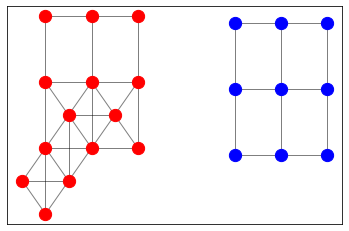

['(3.0,0.0)'] 21307.060894660943
['(3.0,2.0)'] 88305.84357864394
['(3.0,1.0)'] 16827.574603174657


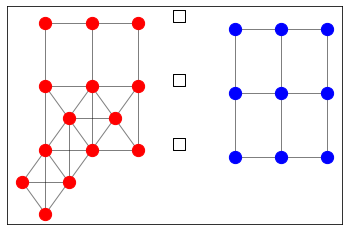

In [22]:
# player1Pos = [[1,1],[1,2],[2,2],[2,3],[2,4],[3,3]]

# player2Pos = [[3,1],[4,1],[4,2],[5,2],[5,3]]

# l = 10
    
# player1Pos = [[1,i] for i in range(l)]

# player2Pos = [[3,i] for i in range(l)]

player1Pos = [[0,0],[1,0],[2,0],[2,1],[2,2],[1,2],[0,2],[0,3]]

player2Pos = [[4,0],[5,0],[6,0],[6,1],[6,2],[6,3],[5,3],[4,3],[4,2]]



# player1Pos = [[1,1],[1,2],[2,1],[2,2],[2,3],[2,4],[3,3],[4,3],[4,4],[4,5],[3,5],[2,5]]

# player2Pos = [[3,1],[4,1],[4,2],[5,2],[5,3],[5,4],[5,5],[3,0],[3,-1],[4,-1],[5,-1],[5,0],[5,1]]

# player1Pos = [[2,1],[2,2],[2,3],[1,3],[1,2],[1,4],[1,5],[2,5],[3,5]]

# player2Pos = [[4,3],[5,3],[5,2],[6,2],[7,2],[7,3],[7,4],[7,5],[6,5],[5,5]]

# player1Pos = [[1,1],[2,1],[2,2],[2,3],[2,4],[3,4],[4,4],[4,3],[4,2],[5,2]]

# player2Pos = [[3,5],[4,5],[5,5],[6,5],[4,4],[4,3],[4,2],[5,2],[6,2],[7,2],[8,2]]

# player1Pos = [[3,3],[4,2],[4,3],[4,4],[4,5],[5,5],[6,5],[7,5],[7,4],[7,3],[7,2],[8,2],[7,1]]

# player2Pos = [[3,5],[4,5],[5,5],[6,5],[4,4],[4,3],[4,2],[5,2],[6,2],[7,2],[8,2]]


player1Pos = [[0,0],[1,0],[2,0],[0,1],[1,1],[2,1],[0,2],[1,2],[2,2],[1.5,0.5],[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[0,-1]]

player2Pos = [[4,0],[5,0],[6,0],[4,1],[5,1],[6,1],[4,2],[5,2],[6,2]]


player1AgentsNumber = len(player1Pos)
player2AgentsNumber = len(player2Pos)

player1Agents = [Agent(1,Pos(i,j)) for (i,j) in player1Pos]
player2Agents = [Agent(2,Pos(i,j)) for (i,j) in player2Pos]


network = Network()
network.r = 1
network.add_agents(player1Agents)
network.add_agents(player2Agents)
network.draw_graph()

possible_positions = network.get_possible_positions()
best_positions = network.get_best_positions(possible_positions,2.,1)
# print(list(map(str,best_positions)))
network.draw_graph(possible_positions = possible_positions)


# possible_positions = network.get_possible_grid_positions()
# best_grid_positions = network.get_best_positions(possible_positions,0.5)
# print(list(map(str,best_grid_positions)))

# drons = [Agent(pos=pos) for pos in best_positions]
# network.add_drons(drons)
# network.draw_graph()
# network.del_drons(drons)

# drons = [Agent(pos=pos) for pos in best_grid_positions]
# network.add_drons(drons)
# network.draw_graph()
# network.del_drons(drons)

# network.write_info_file(filename='my_network_with_nodes.txt')
# network.write_info_file([Pos(2,4),Pos(5,4)],'my_network_with_nodes2.txt')
# network.write_info_file(min_diam_pos2,'my_network_with_nodes3.txt')  


# print(network.get_pos_value(0.5,Pos(4,3)))
# print(network.get_pos_value(0.5,Pos(2,0)))



network.write_info_file(best_positions,'my_network_with_nodes.txt')
i = 1
for positions in combinations(possible_positions, 1):
    if positions != best_positions:
        i += 1
        network.write_info_file(positions,'my_network_with_nodes'+str(i)+'.txt')  
        


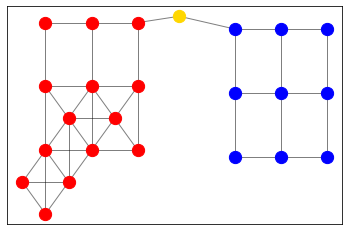

2


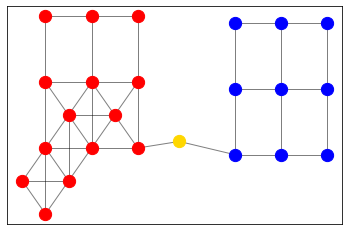

3


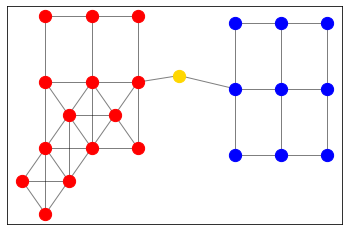

In [27]:
drons = [Agent(pos=pos) for pos in best_positions]
network.add_drons(drons)
network.draw_graph(pngname='graph.png')
network.del_drons(drons)

i = 1
for positions in combinations(possible_positions, 1):
    if positions != best_positions:
        drons = [Agent(pos=position) for position in positions]
        network.add_drons(drons)
        i += 1
        print(i)
        network.draw_graph(pngname='graph'+str(i)+'.png')
        network.del_drons(drons)


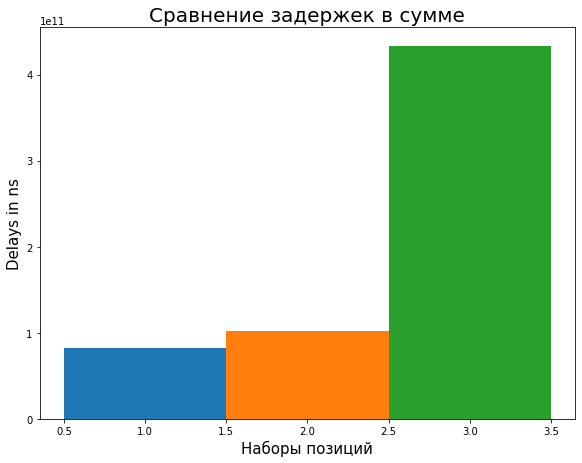

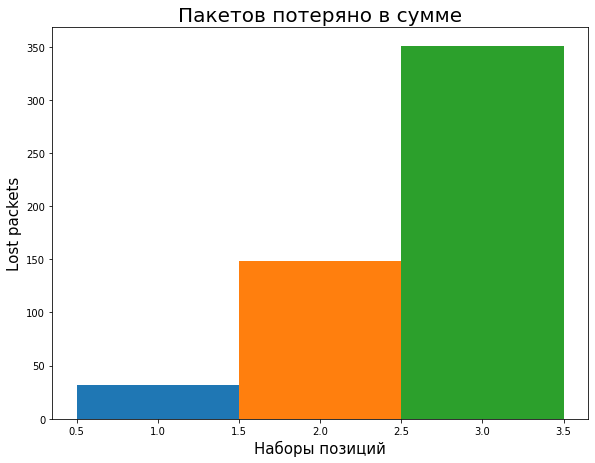

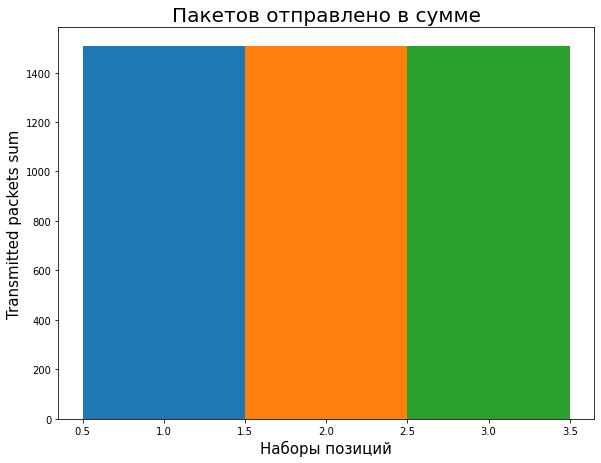

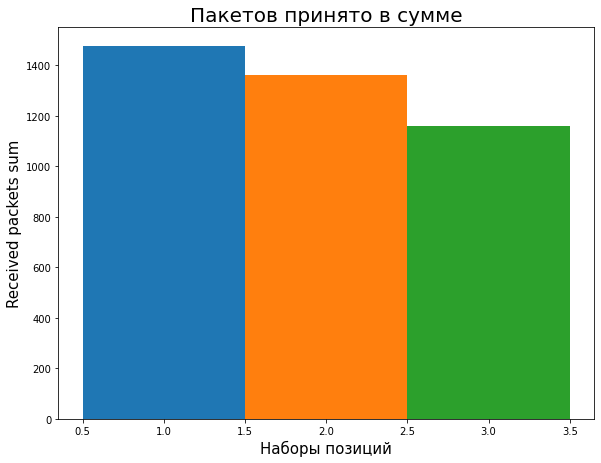

In [28]:
info_list = [parse_flowmon('p2p_manet.flowmon')]
for i in range(2,len(possible_positions)+1):
    info_list.append(parse_flowmon('p2p_manet'+str(i)+'.flowmon'))
    
info_list[1],info_list[2] = info_list[2],info_list[1]
    
plot_sum_bars(info_list,legend_labels=None)

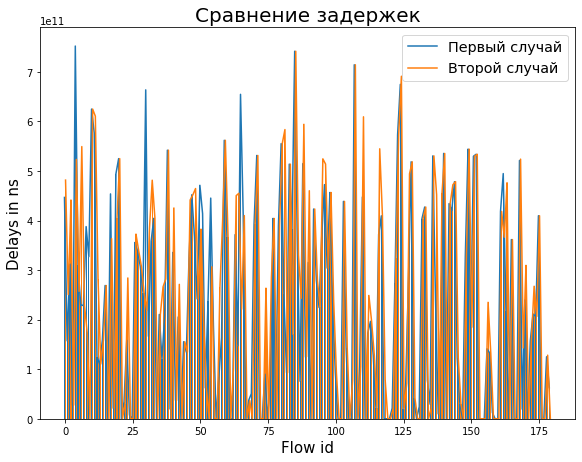

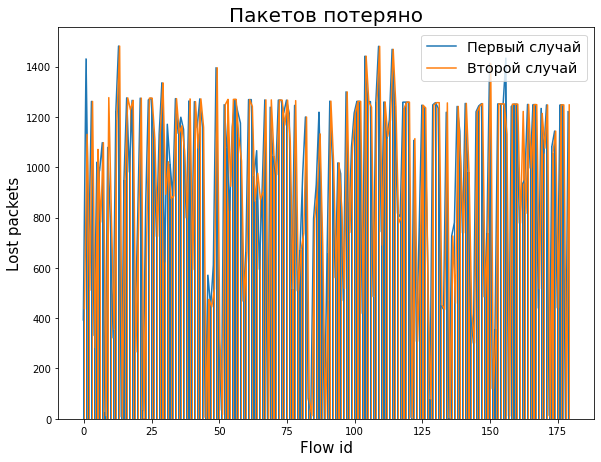

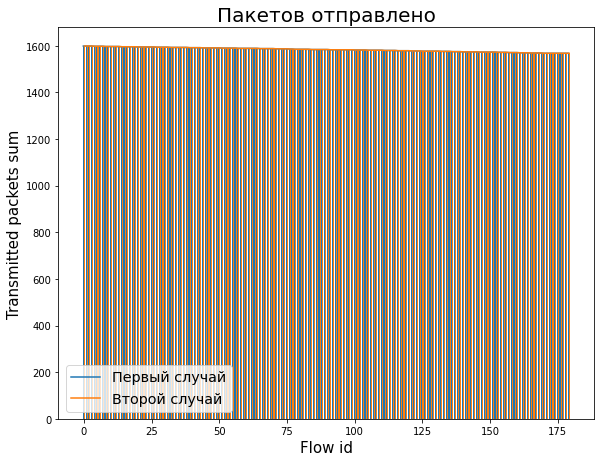

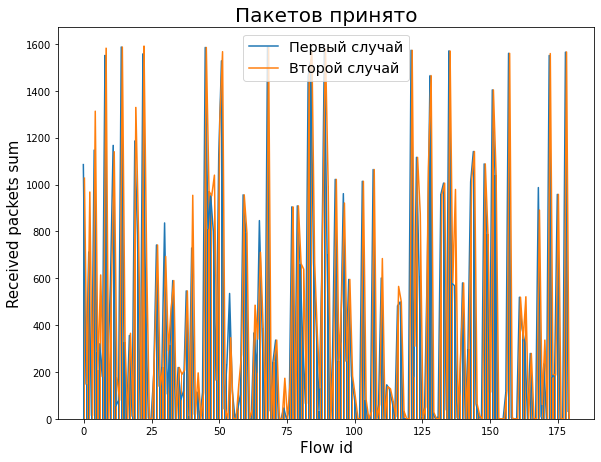

In [37]:
plot_bars(info_list,info_list2)

In [195]:
def get_intersections(points,r):
    points = tuple(points)
    intersections = [[],[]]
    for p1 in range(len(points)):
        for p2 in range(p1+1,len(points)):
            dist = points[p1].get_distance(points[p2])
            #Рассмотреть случай  (dist == 0)
            if dist == 0:
                if p1 != p2:
                    pass
            elif dist < 2*r:
                h = (r**2-(dist/2)**2)**0.5
                p12 = (points[p2]-points[p1])
                center = points[p1] + p12/2
                intersections[0] += [[],[]]
                intersections[1] += [Pos(center.i+(h/dist)*p12.j,center.j-(h/dist)*p12.i)
                                      ,Pos(center.i-(h/dist)*p12.j,center.j+(h/dist)*p12.i)]
            

    for i in range(len(intersections[1])):
        for point2 in points:
            if intersections[1][i].get_distance(point2) <= r:
                intersections[0][i].append(point2)
                
    intersection_dict = {}
    for point_set,point in zip(intersections[0],intersections[1]):  
        if intersections[0].count(point_set) == len(point_set):
            point_set = tuple(point_set)
            if intersection_dict.get(point_set) == None:
                intersection_dict[point_set] = [point]
            else:
                intersection_dict[point_set].append(point)
                
    return list(intersection_dict.values())

a = Pos(0,0)
b = Pos(10,0)
c = Pos(-10,0)
d = Pos(5,6)
r=6
points = [a,b,c]

list(map(str,list(map(lambda x: np.mean(np.array(x)),get_intersections(points,r)))))
                


['(5.0,0.0)', '(-5.0,0.0)']

In [77]:
def get_intersections(points,r):
    points = tuple(set(points))
    intersections = [[],[]]
    for p1 in range(len(points)):
        for p2 in range(p1+1,len(points)):
            dist = points[p1].get_distance(points[p2])
            if dist < 2*r:
                h = (r**2-(dist/2)**2)**0.5
                p12 = (points[p2]-points[p1])
                center = points[p1] + p12/2
                intersections[0] += [[],[]]
                intersections[1] += [Pos(center.i+(h/dist)*p12.j,center.j-(h/dist)*p12.i)
                                      ,Pos(center.i-(h/dist)*p12.j,center.j+(h/dist)*p12.i)]
            

    for i in range(len(intersections[1])):
        for point2 in points:
            if intersections[1][i].get_distance(point2) <= r:
                intersections[0][i].append(point2)
                
    intersection_dict = {}
    for point_set,point in zip(intersections[0],intersections[1]):  
        max_len = 0
        for intersection in intersections[0]:
            if set(point_set).issubset(set(intersection)):
                if max_len < len(intersection):
                    max_len = len(intersection)
                    max_intersection = intersection
        
        if len(point_set) == max_len:       
            point_set = tuple(point_set)
            if intersection_dict.get(point_set) == None:
                intersection_dict[point_set] = [point]
            else:
                intersection_dict[point_set].append(point)
                
    return list(intersection_dict.values())

a = Pos(0,0)
b = Pos(10,0)
c = Pos(5,6)
d = Pos(5,0)
r=6
points = [a,a]

list(map(str,list(map(lambda x: np.mean(np.array(x)),get_intersections(points,r)))))
                


[]

[<__main__.Pos object at 0x7fa2f41e3910>, <__main__.Pos object at 0x7fa2f41e32b0>]


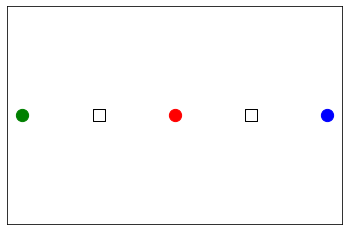

In [111]:
network.r = 5

positions = set()
agents_pos = {}
for agent in network.agents:
    positions.update(agent.neighbors_pos(network.r))
possible_positions = []

for pos in positions:
    player_list = set()
    for agent in network.agents:
        if pos.get_distance(agent.pos) <= network.r:
            player_list.add(agent.player_id)
            if len(player_list) > 1:
                break
    if len(player_list) > 1:
        possible_positions.append(pos)
print(possible_positions)
network.draw_graph(possible_positions = possible_positions)


In [ ]:
def get_possible_grid_positions(self):
    positions = set()
    agents_pos = {}
    for agent in network.agents:
        positions.update(agent.neighbors_pos(network.r))
    possible_positions = []

    for pos in positions:
        player_list = set()
        for agent in network.agents:
            if pos.get_distance(agent.pos) <= network.r:
                player_list.add(agent.player_id)
                if len(player_list) > 1:
                    break
        if len(player_list) > 1:
            possible_positions.append(pos)
    return possible_positions

In [ ]:
network_cp = network
for pos1,pos2 in network_cp.get_pareto_optimal_pos():
    drons = [Agent(pos=pos1),Agent(pos=pos2)]
    subnetA = network_cp.get_player_subnet(1,True)
    subnetB = network_cp.get_player_subnet(2,True)
    print(subnetA.get_diameter(pos1,pos2),subnetB.get_diameter(pos1,pos2))
    network_cp.add_drons(drons)
    print(network_cp.func_var1(pos1,pos2))

    
    network_cp.draw_graph()
    network_cp.del_drons(drons)

In [ ]:
network_cp = network
pos1 = Pos(2,4)

dron = Agent(pos=pos1)
network_cp.add_dron(dron)
bc = nx.betweenness_centrality(network_cp.graph)
print(bc[dron])

network_cp.draw_graph()
network_cp.del_dron(dron)